### Loading Lib

In [ ]:
import torch
from torch import nn
from pathlib import Path
import torchvision
from torchvision import transforms,datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import random
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading data

In [33]:
# dir_path = Path("/kaggle/input/faceshape-dataset/FaceShape Dataset")
# train_dir = dir_path/"training_set"
# test_dir = dir_path/"testing_set"

dir_path = Path("FaceShape Dataset")
train_dir = dir_path/"train"
test_dir = dir_path/"test"
train_dir

WindowsPath('FaceShape Dataset/train')

### Loading random images

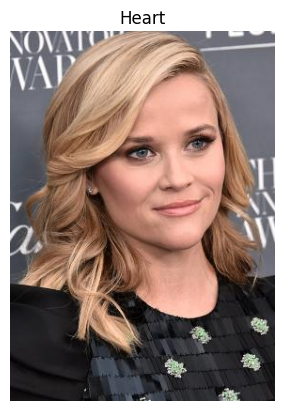

In [34]:
images = list(dir_path.glob("*/*/*.jpg"))

random_img = random.choice(images)
t = random_img.parent.stem
img = Image.open(random_img)
plt.title(t)
plt.imshow(img)
plt.axis('off')
plt.show()

### Creating a data_transform

In [35]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

### Checking Some Random Transform Images 

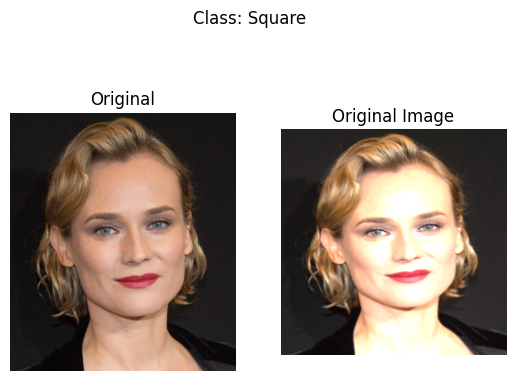

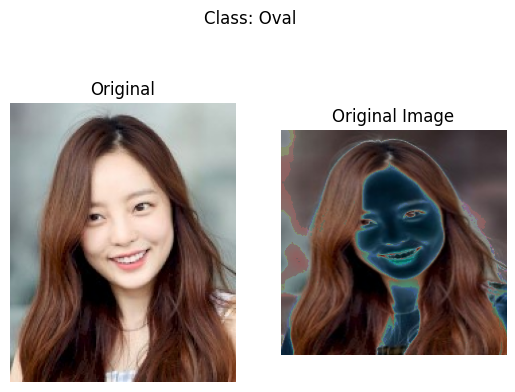

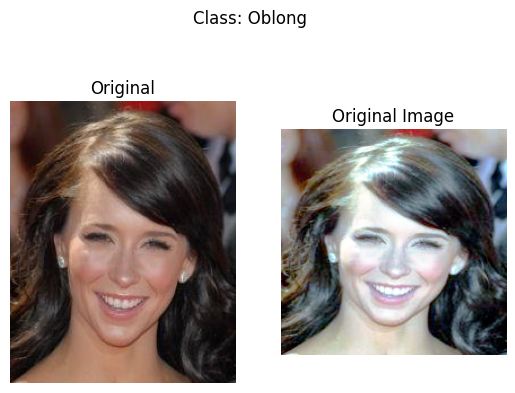

In [36]:
def plot_random(image_path_list,transform,n=3,seed=0):
    # sorted(image_path_list)
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_path_list,k=n)

    for i in random_image_paths:
        # t = i.parent.stem
        with Image.open(i) as img:
            fig,ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(img)
            ax[0].set_title("Original")
            ax[0].axis("off")

            transform_img = transform(img)
            ax[1].imshow(transform_img.permute(1,2,0))
            ax[1].set_title("Original Image")
            ax[1].axis("off")

            fig.suptitle(f"Class: {i.parent.stem}")
    plt.show()


plot_random(images,data_transforms,3)
# random_image

### Creating Dataset and dataloader

In [37]:
train_dataset = datasets.ImageFolder(root=train_dir,transform=data_transforms)
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True) 

test_dataset = datasets.ImageFolder(root=test_dir,transform=data_transforms)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=True)

### Finne Tunning the Vit model

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k",num_labels=5,ignore_mismatched_sizes=True)

#checking if multiple GPUs are available

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)
model.to(device)

#freezing all the layers of the model except the classifier layer
for param in model.parameters():
    param.requires_grad = False

#unfreezing the classifier layer
classifier_params = model.module.classifier.parameters() if isinstance(model, torch.nn.DataParallel) else model.classifier.parameters()
for param in classifier_params:
    param.requires_grad = True


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_params,lr=1e-3)
train_loss_model = []
train_acc_model = []
test_loss_model = []
test_acc_model = []
EPOCHS = 5

#Training Loop
for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model.train()

    train_loss_epoch = 0
    train_acc_epoch = 0
    test_loss_epoch = 0
    test_acc_epoch = 0

    # Training Step
    for batch_idx, (X, y) in enumerate(train_dataloader):  
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model(X).logits
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc
        test_loss_model.append(loss.item())
        test_acc_model.append(acc)

        # Print batch info every 8 batches
        if batch_idx % 200 == 0:
            print(f"Batch {batch_idx} | Train loss: {loss.item():.5f} | Train acc: {acc:.2f}")

    train_loss_epoch /= len(test_dataloader)
    train_acc_epoch /= len(train_dataloader)

    # Evaluation
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc
            test_loss_model.append(loss.item())
            test_acc_model.append(acc)

    test_loss_epoch /= len(test_dataloader)
    test_acc_epoch /= len(test_dataloader)
    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f} | Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")

### PLotting Lost Curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_curves(train_loss, train_acc, test_loss, test_acc, batches_per_epoch):
    # Aggregate per epoch
    num_epochs = len(train_loss) // batches_per_epoch
    
    train_loss_epoch = [np.mean(train_loss[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(num_epochs)]
    test_loss_epoch = [np.mean(test_loss[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(num_epochs)]
    train_acc_epoch = [np.mean(train_acc[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(num_epochs)]
    test_acc_epoch = [np.mean(test_acc[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(num_epochs)]
    
    epochs = range(num_epochs)

    plt.figure(figsize=(12, 5))

    # Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_epoch, label='Train Loss', marker='o')
    plt.plot(epochs, test_loss_epoch, label='Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_epoch, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_acc_epoch, label='Test Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()
# batches_per_epoch = len(train_dataloader_1)

# plot_loss_curves(train_loss, train_acc, test_loss, test_acc, batches_per_epoch)


batches_per_epoch = len(train_dataloader)
plot_loss_curves(train_loss_model, train_acc_model, test_loss_model, test_acc_model, batches_per_epoch)

### Predicting on some random images

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def get_random_test_samples(test_dataloader, num_samples=10):
    test_batch = next(iter(test_dataloader))
    test_images, test_labels = test_batch
    
    random_indices = random.sample(range(len(test_images)), min(num_samples, len(test_images)))
    
    random_images = test_images[random_indices]
    random_labels = test_labels[random_indices]
    resize_transform = transforms.Resize((224, 224))
    random_images = torch.stack([resize_transform(img) for img in random_images])
    return random_images, random_labels

model.eval()

random_images, random_labels = get_random_test_samples(test_dataloader, num_samples=5)

with torch.no_grad():
    random_images = random_images.to(next(model.parameters()).device)
    
    pred_logits = model(random_images).logits
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

random_images = random_images.cpu()
random_labels = random_labels.cpu()
pred_labels = pred_labels.cpu()

plt.figure(figsize=(15, 10))
for i, (image, true_label, pred_label) in enumerate(zip(random_images, random_labels, pred_labels)):
    plt.subplot(1, 5, i+1)
    img = image.permute(1, 2, 0).numpy()
    
    if img.max() > 1.0:
        img = img / 255.0
    
    plt.imshow(img)
    
    correct = true_label.item() == pred_label.item()
    color = 'green' if correct else 'red'
    
    plt.title(f"True: {true_label.item()}\nPred: {pred_label.item()}", 
              color=color, fontweight='bold')
    
    if not correct:
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        plt.gca().spines['top'].set_linewidth(3)
        plt.gca().spines['bottom'].set_linewidth(3)
        plt.gca().spines['left'].set_linewidth(3)
        plt.gca().spines['right'].set_linewidth(3)
    
    plt.axis("off")
plt.tight_layout()
plt.show()
_ = get_random_test_samples(test_dataloader, num_samples=10)